# Check your versions

In [5]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.16.5
pandas 0.25.1
scipy 1.3.1
sklearn 0.21.3
lightgbm 2.0.6


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

## Setup

In [1]:
# garbage collector
import gc
# data manipulation
import numpy as np
import pandas as pd
# models used in the ensemble
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
# misc
from sklearn.metrics import r2_score
from itertools import product
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
# setup
%matplotlib inline 
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)


## Useful Functions

In [14]:
def downcast_dtypes(df):
    '''
    Changes column types in the dataframe: 
    `float64` type to `float32`
    `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df


In [15]:
def sales_groupby(all_data, sales, cols_to_agg, target_name):
    '''
    Sums sales by cols_to_agg and rename to
    target_name.
    '''

    sales_grouped = (
        sales
        .groupby(cols_to_agg, as_index=False)
        .agg({'item_cnt_day':'sum'})
        .rename(columns={'item_cnt_day': target_name})
    )

    agg_sales = pd.merge(all_data, sales_grouped, how='left', on=cols_to_agg).fillna(0)
    return agg_sales


___

# ETL
## Load Data

In [16]:
# load data
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

# limit scope to three stores only
sales = sales[sales['shop_id'].isin([26, 27, 28])]


## Monthly Aggregation

In [17]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']


In [18]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    shops_items = product(*[cur_shops, cur_items, [block_num]])
    grid.append(np.array(list(shops_items),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

# delete unused data
del block_num, cur_shops, cur_items, shops_items


In [19]:
# shop-item-month
cols_to_agg = ['shop_id', 'item_id', 'date_block_num']
all_data = sales_groupby(grid, sales, cols_to_agg, 'target')

# shop-month
cols_to_agg = ['shop_id', 'date_block_num']
all_data = sales_groupby(all_data, sales, cols_to_agg, 'target_shop')

# item-month
cols_to_agg = ['item_id', 'date_block_num']
all_data = sales_groupby(all_data, sales, cols_to_agg, 'target_item')

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)

# delete unused data
del cols_to_agg 


In [20]:
# head
all_data.head()


,shop_id,item_id,date_block_num,target,target_shop,target_item
0,28,7738,0,4.0,7057.0,11.0
1,28,7737,0,10.0,7057.0,16.0
2,28,7770,0,6.0,7057.0,10.0
3,28,7664,0,1.0,7057.0,1.0
4,28,7814,0,2.0,7057.0,6.0


In [21]:
# delete unused data
del grid
gc.collect();


## Lag Features

We will use lags from the previous 1, 2, 3, 4, 5, 12 months.

In [22]:
# columns for which we will create lag features
cols_to_lag = list(all_data.columns.difference(index_cols)) 
# lags
month_shift_range = [1, 2, 3, 4, 5, 12]
# init lag df
lag_data = all_data.copy()

# loop across all lags
for month_shift in tqdm_notebook(month_shift_range):
    # copy the relevant columns
    shifted_data = all_data[index_cols + cols_to_lag].copy()

    # update the months (add lag for the merge step later)
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + month_shift

    # rename columns to indicate the lag
    lag_renaming_mapper = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_lag else x
    shifted_data = shifted_data.rename(columns=lag_renaming_mapper)

    # add these new lag features for all the combos of index_cols that exist on the current month
    lag_data = pd.merge(lag_data, shifted_data, on=index_cols, how='left').fillna(0)

# delete unused data
del cols_to_lag, month_shift_range, month_shift, shifted_data, lag_renaming_mapper


## Item Category & Cleanup

In [23]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
lag_data = pd.merge(lag_data, item_category_mapping, how='left', on='item_id')

# Don't use old data from year 2013
lag_data = lag_data.loc[lag_data['date_block_num'] >= 12] 

# downcast numbers
lag_data = downcast_dtypes(lag_data)

# List of all lagged features
lag_cols = [col for col in lag_data.columns if col not in all_data.columns] 

# delete unused data
del item_category_mapping


In [24]:
# head
lag_data.head(5)


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
120669,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
120670,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
120671,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
120672,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
120673,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


In [25]:
del all_data
gc.collect();


## Train/test split

For the sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.


In [38]:
# use last month as test set
dates = lag_data['date_block_num']
last_block = dates.max()
print('Test date_block_num is {:d}'.format(last_block))

# dates split
is_dates_train = dates <  last_block
is_dates_test = dates == last_block

dates_train = dates[is_dates_train]
dates_test  = dates[is_dates_test]

# only keep [shop_id, item_id] and lag columns for training
cols_to_drop = list(set(list(lag_data.columns)) \
               - (set(lag_cols)|set(index_cols))) \
               + ['date_block_num'] 

# split dataset & drop unwanted features
X_train = lag_data.loc[is_dates_train].drop(cols_to_drop, axis=1)
X_test =  lag_data.loc[is_dates_test].drop(cols_to_drop, axis=1)
y_train = lag_data.loc[is_dates_train, 'target'].values
y_test =  lag_data.loc[is_dates_test, 'target'].values


Test date_block_num is 33


___

# Ensembling

You need to implement a basic stacking scheme. We have a time component here, so we will respect timeline constraints. 

_Note: we always use first level models to build two datasets: the test meta-features and 2nd level train-metafeatures._

## First level models 
### Test meta-features

We fit a linear regression and LightGBM on numeric columns, then get predictions for the last month.


In [ ]:
# LightGBM parameters
lgb_params = {
    'nthread': 1, 
    'metric': 'rmse',
    'objective': 'mse', 
    'feature_fraction': 0.75,
    'learning_rate': 0.03,
    'num_leaves': 2**7,
    'min_data_in_leaf': 2**7, 
    'bagging_seed': 2**7, 
    'bagging_fraction': 0.75, 
    'bagging_freq':1,
    'verbose': 0 
}


In [27]:
# linear regression
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)
print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

# LightGBM
model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)
print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

# stack features
X_test_level2 = np.c_[pred_lr, pred_lgb] 


Test R-squared for linreg is 0.743180
Test R-squared for LightGBM is 0.738391


### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [53]:
# months to consider for level2 (K in M+K)
months_level2 = [27, 28, 29, 30, 31, 32]

# dates ranges - level2
is_months_level2 = dates_train.isin(months_level2)
dates_train_level2 = dates_train[is_months_level2]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[is_months_level2]

# And here we create 2nd level feature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])


In [55]:
for cur_block_num in months_level2:

    # track progress
    print(cur_block_num)
    
    # idx range
    is_train_K = dates_train < cur_block_num
    is_test_K = dates_train == cur_block_num

    # training subset
    X_train_K = X_train[is_train_K]
    y_train_K = y_train[is_train_K]
    X_test_K = X_train[is_test_K]

    # linear regression
    lr = LinearRegression()
    lr.fit(X_train_K.values, y_train_K)
    pred_lr = lr.predict(X_test_K.values)

    # LightGBM
    model = lgb.train(lgb_params, lgb.Dataset(X_train_K, label=y_train_K), 100)
    pred_lgb = model.predict(X_test_K)

    # add OOF predictions
    is_test_K_preds = dates_train_level2 == cur_block_num
    X_train_level2[is_test_K_preds, 0] = pred_lr
    X_train_level2[is_test_K_preds, 1] = pred_lgb


27
28
29
30
31
32


In [56]:
# Sanity check
assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))


Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

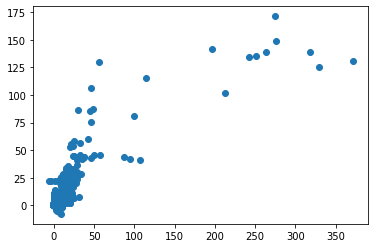

In [58]:
# YOUR CODE GOES HERE
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])


## Second-level model

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 


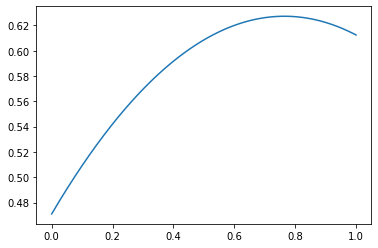

In [59]:
alphas_to_try = np.linspace(0, 1, 1001)
r2_scores = []

# YOUR CODE GOES HERE
for alpha in alphas_to_try:
    mix_preds = alpha * X_train_level2[:, 0] + (1-alpha) * X_train_level2[:, 1]
    r2_scores.append(r2_score(y_train_level2, mix_preds))

plt.plot(alphas_to_try, r2_scores)


In [65]:
best_alpha = np.array(r2_scores).argmax()/1000
r2_train_simple_mix = max(r2_scores)

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))


Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [67]:
test_preds = best_alpha * X_test_level2[:, 0] + (1-best_alpha) * X_test_level2[:, 1]
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)


Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.


In [71]:
# YOUR CODE GOES HERE

# linear regression
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)
pred_train_level2 = lr.predict(X_train_level2)
pred_test_level2 = lr.predict(X_test_level2)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

Compute R-squared on the train and test sets.

In [70]:
# train preds
train_preds = lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

# test preds
test_preds = lr.predict(X_test_level2)
r2_test_stacking = r2_score(y_test, test_preds)

# comparative performance
print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)


Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.


In [ ]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)